# Contexte
Ton ancien collègue Bernardo t'appelle. Il est très inquiet. Son ordinateur est cassé et il n'avait aucune sauvegarde.

Il l'avait posé sur une table, et le vent l'a fait tombé. Il te l'a déjà dit 100 fois : le vent trop fort ne fait que du tort à son activité.

Bernardo gère les stocks de 4 boutiques. Il avait l'habitude de prévoir les ventes des prochaines semaines pour commander ses nouveaux stocks.

Il vient juste de retrouvé un ancien fichier, avec les volumes de ventes de l'année 2019 d'une seule boutique, mais il ne sait pas laquelle. Il se rappelle que tu es le Zorro de la data. Il t'appelle donc à la rescousse.

# Attendu

1. Analyse descriptive exploratoire (EDA)<br>
Tu commenceras par explorer les données de vente (fichier ici), et tu mettras en avant notamment les saisonnalités, les produits et la complétude des données.

2. Trouver la boutique correspondante<br>
Tu détermineras à quelle boutique correspond ce fichier de ventes. Pour cela, tu pourras t'aider de données météo. En effet, Bernardo nous a indiqué que les ventes sont corrélées à la météo.
Les boutiques se situent à Bordeaux, Lille, Lyon et Marseille. Tu trouveras les historiques de météo ici pour Bordeaux, Lille, Lyon, et Marseille.

3. Explication de l'impact de la météo<br>
Tu détermineras (par corrélation, ou par Machine Learning) l'importance de chaque dimension. Tu mettras en avant les variables (température, vitesse du vent, etc...) qui semblent les plus corrélées aux ventes, et celles qui sont le moins corrélées. Bernardo a-t-il raison : est-ce bien le vent qui a le plus d'impact sur les ventes ?

4. Prévisions de ventes<br>
Bernardo a récupéré des prévisions météo sur une semaine (le fichier est ici). Il aimerait que tu lui fasses une prévision des ventes correspondant à cette période, pour qu'il puisse acheter les bons stocks de produit. Tu devras donc indiquer le stock total minimum que tu conseilles à Bernardo de commander pour la semaine prochaine, afin de pouvoir répondre à la demande, sans faire des sur-stocks.

# Initialisation du projet

## Import des librairies

In [1]:
# Analyse descriptive
import pandas as pd
from datetime import datetime, timedelta, timezone
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from IPython.display import display
from termcolor import colored
from scipy.stats import bartlett, shapiro, spearmanr
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder


import numpy as np
import statistics as stats
import math



# Prédiction
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, ElasticNet, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import *
from sklearn.model_selection import train_test_split, GridSearchCV


## Paramètres

In [2]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 22)

## Import des fichiers

In [3]:
path='./Fichiers/'
forecast=pd.read_csv(path+"forecast.csv")
marseille=pd.read_csv(path+"marseille2019.csv", sep=",",skiprows = 3)
lyon=pd.read_csv(path+"lyon2019.csv", sep=",",skiprows = 3)
bordeaux=pd.read_csv(path+"bordeaux2019.csv", sep=",",skiprows = 3)
lille=pd.read_csv(path+"lille2019.csv", sep=",",skiprows = 3)
sales=pd.read_csv(path+"history.csv")

## Variables

In [4]:
items_color={'A':'skyblue', 'B':'hotpink'}

In [5]:
alpha = 0.05 # pour les différents tests statistiques, valeur du seuil


## Fonctions

In [6]:
def create_moving_average (df, rolling_number) :
    '''
Add a moving_average column in dataframe

Parameters
----------
    - df : the dataframe to add the column in
    - rolling_number : the value of moving average
    '''
    
    moving_average = df.sales.rolling(rolling_number, center=True).mean()
    df["moving_average"] = moving_average


In [7]:
def plot_moving_average (df_moving_avg, df, product) :
    
    '''
Plot the moving average v. reals sales

Parameters
----------
    - dataframe containing moving average data
    - original dataframe
    - product to plot
    
Return
------
The graph to plot
    '''
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_moving_avg.query("item==@product"), x="date",y='moving_average',linestyle='solid', color="skyblue")
    sns.lineplot(data=df.query("item==@product"), x="date",y='sales', linestyle=":", color="hotpink")
    plt.legend(["Moyenne mobile des ventes","Total des ventes"])
    plt.xlabel("Moyenne mobile")
    plt.ylabel("Date")
    plt.title(f"Evolution des ventes pour le produit {product}")
    plt.show()
    plt.close()


In [143]:

def plot_product_sales (dataframe, x, y, title=None, x_title=None, y_title=None, style=None) :
    '''
Plot the sales by product
Parameters
----------
 - dataframe
 - x = abcissa data
 - y = ordinate data
 - title : the title of the graph
 - x_title : abcissa name
 - y_title : ordinate name
 - style : line style

Returns
-------
The graph to plot
    '''
    
    if style is None:
        style='linear'
    
    fig=px.line(
        data_frame=dataframe.query("item in ['A','B']"), 
        x=x, 
        y=y,
        title=title, color="item",
        color_discrete_map=items_color,
        width=1080, 
        height=720,
        line_shape=style
    ).update_layout(xaxis={"title": x_title}, yaxis={"title": y_title})

    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    fig.show()

# 1. Analyse descriptive exploratoire

## Qualité des données

In [9]:
sales

,DATE,ITEM,SALES
0,02-01-2019,A,113
1,03-01-2019,A,143
2,04-01-2019,A,145
3,05-01-2019,A,167
4,06-01-2019,A,202
...,...,...,...
515,25-12-2019,B,96
516,26-12-2019,B,85
517,27-12-2019,B,87
518,28-12-2019,B,79


### Conversion des données

Par commodité, je passe le nom des colonnes en minuscule

In [10]:
sales.columns = sales.columns.str.lower()
sales

,date,item,sales
0,02-01-2019,A,113
1,03-01-2019,A,143
2,04-01-2019,A,145
3,05-01-2019,A,167
4,06-01-2019,A,202
...,...,...,...
515,25-12-2019,B,96
516,26-12-2019,B,85
517,27-12-2019,B,87
518,28-12-2019,B,79


In [11]:
sales.dtypes

date     object
item     object
sales     int64
dtype: object

Je convertis l'objet "date" en date

In [12]:
sales.date=pd.to_datetime(sales["date"], format="%d-%m-%Y", )
sales.dtypes

date     datetime64[ns]
item             object
sales             int64
dtype: object

### Détection d'anomalies

In [13]:
sales.describe()

,sales
count,520.000000
mean,98.207692
std,61.444707
min,0.000000
25%,48.000000
50%,87.000000
75%,143.000000
max,282.000000


In [14]:
sales.nunique()

date     260
item       2
sales    185
dtype: int64

**Note**<br>
Il  n'y a que 2 types de produits et pas d'erreur de données notables dans l'observation du describe.<br>
Nous avons 260 dates sur 365 jours dans l'année.

### Valeurs nulles

Je regarde s'il y a des valeurs nulles ou valant 0.

In [15]:
print (f" Il y a {sales.isnull().sum().sum()} produit(s) ayant une valeur nulle.")

 Il y a 0 produit(s) ayant une valeur nulle.


In [16]:
no_sales=sales[sales.loc[:,"sales"]==0]
total_no_sales = no_sales["sales"].count()
print (f"Il y a {total_no_sales} jours sans aucune vente.")

Il y a 23 jours sans aucune vente.


In [17]:
print (f"Les produits concernés par l'absence de vente sont :")
for i in no_sales.item.unique():
    print (f"- Produits {i}")

Les produits concernés par l'absence de vente sont :
- Produits B


### Imputation des valeurs manquants

Je vais remplacer les valeurs manquantes pour faciliter ensuite les divers traitements.<br>
Je ne peux pas appliquer la méthode KNNimputer car je n'ai pas que des variables numériques.<br>
Je vais imputer par la fonction d'interpolation linéaire.

Je regarde la distribution des ventes avant imputation

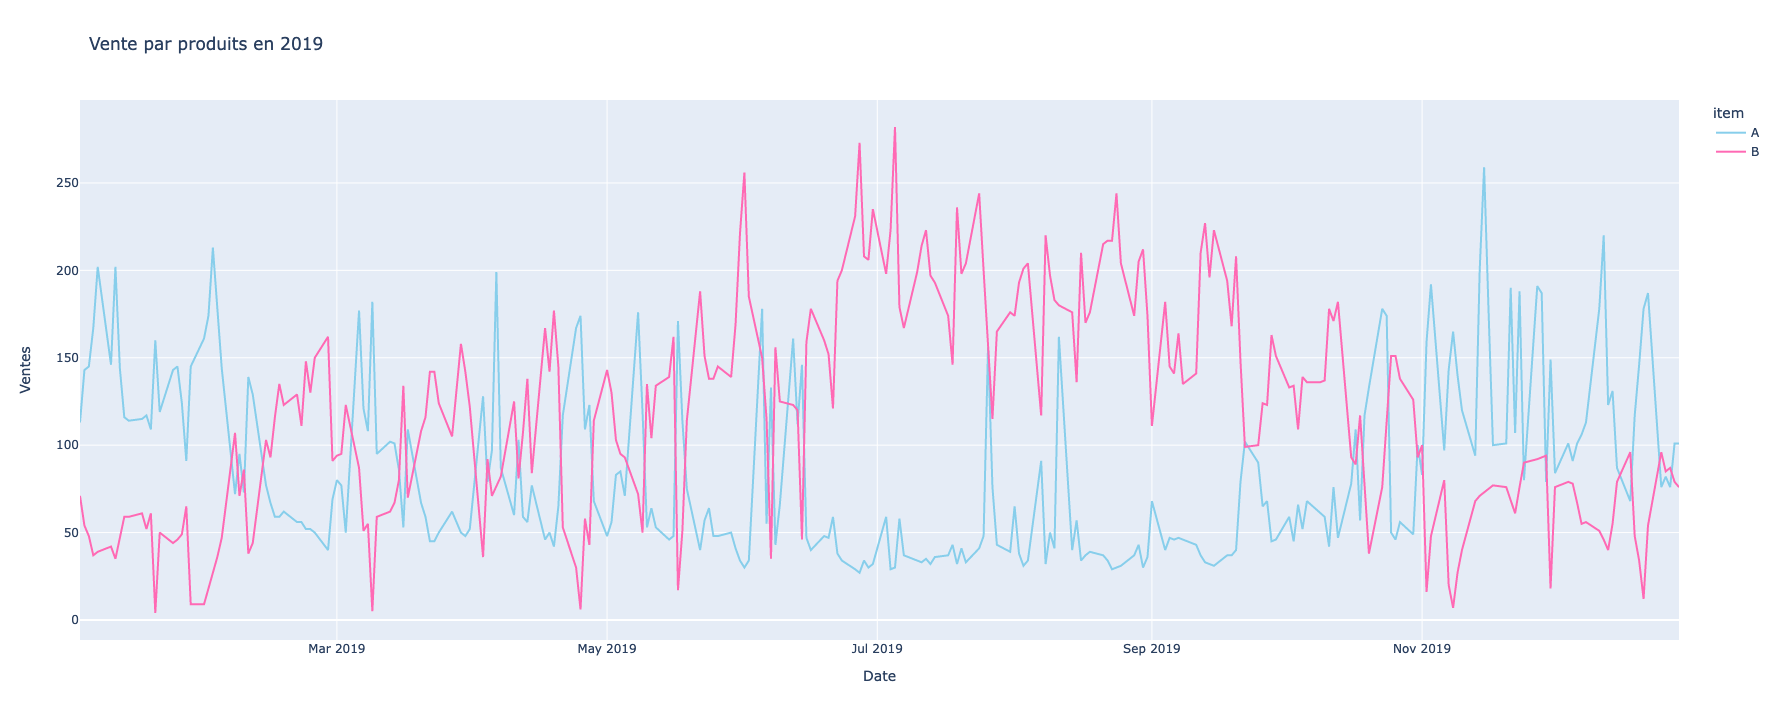

In [144]:
plot_product_sales(dataframe=sales, x='date', y="sales", title="Vente par produits en 2019", x_title="Date", y_title="Ventes")

Pour pouvoir utiliser l'interpolation, je remplace mes 0 par NaN.

In [19]:
sales["sales"].replace(0, np.nan, inplace=True)

In [20]:
sales.isna().sum()

date      0
item      0
sales    23
dtype: int64

Je procède à l'imputation

In [21]:
sales.sales.interpolate(method='linear', inplace=True)
sales.sales = np.ceil(sales.sales).astype(int)

Vérification

In [22]:
sales.iloc[no_sales.index,:]

,date,item,sales
281,2019-01-31,B,18
282,2019-02-01,B,27
305,2019-03-06,B,87
328,2019-04-06,B,77
340,2019-04-24,B,30
350,2019-05-08,B,72
370,2019-06-05,B,150
375,2019-06-12,B,123
407,2019-07-26,B,158
419,2019-08-11,B,180


## Analyse des ventes par produit


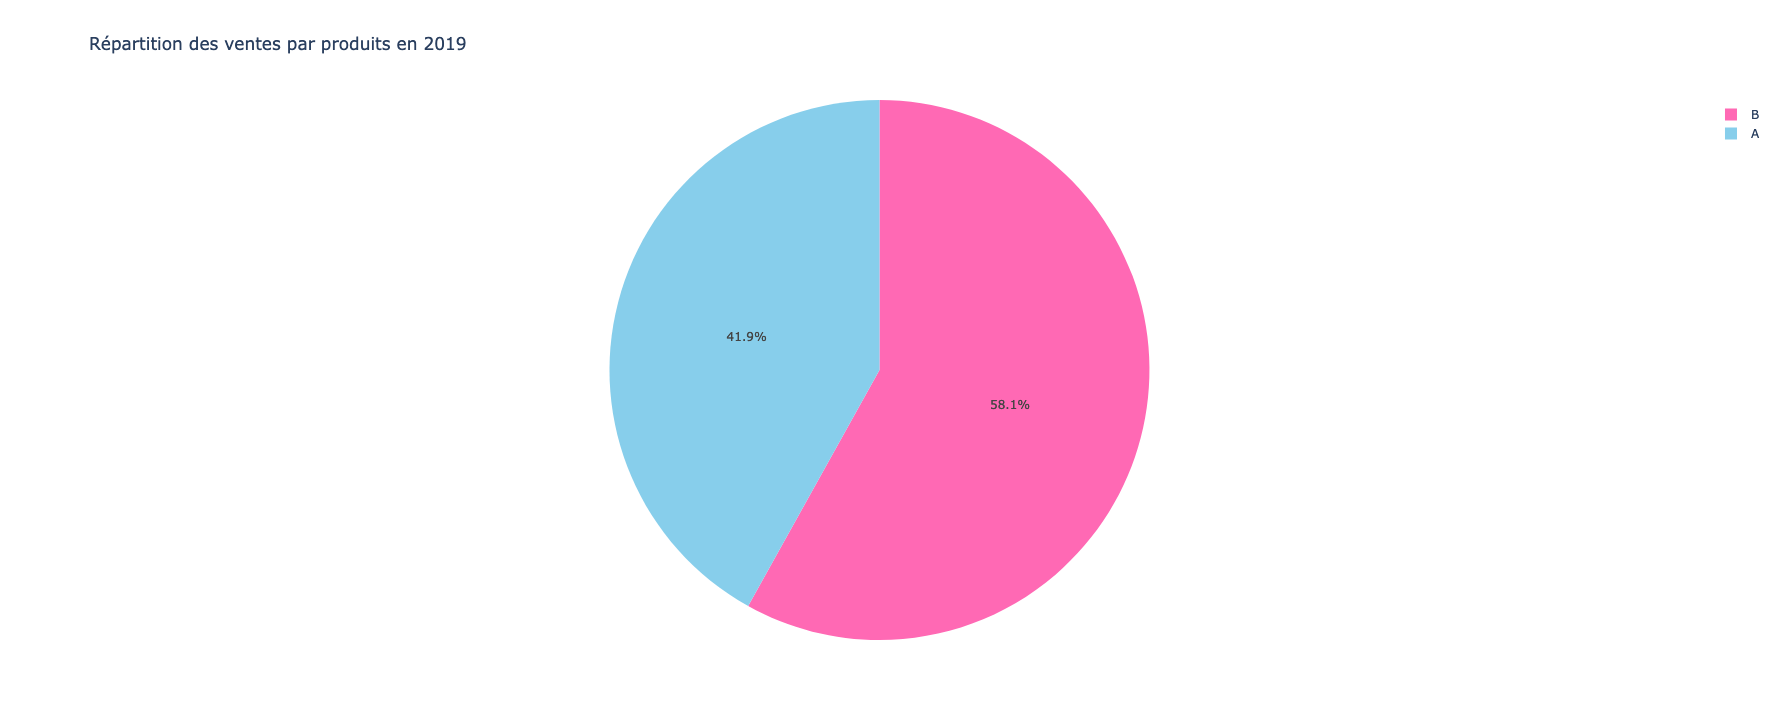

In [23]:
fig = px.pie(data_frame = sales, values="sales", names="item", width=1080, height=720, color = 'item', title="Répartition des ventes par produits en 2019",
             color_discrete_map=items_color)
fig.show()

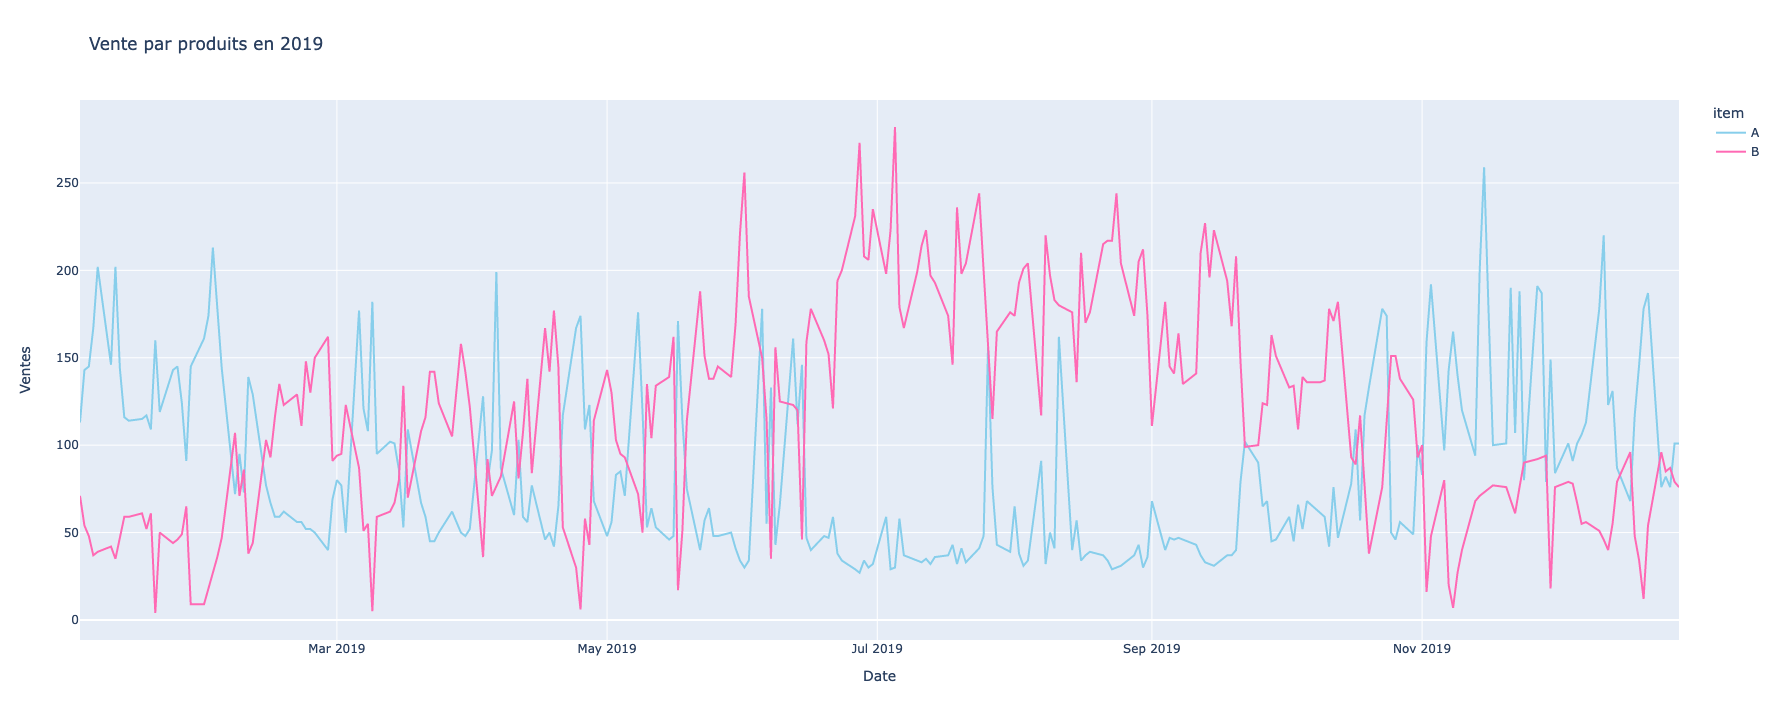

In [24]:
plot_product_sales(dataframe=sales, x='date', y="sales", title="Vente par produits en 2019", x_title="Date", y_title="Ventes")

**Note** <br>
Avec ces 2 graphiques superposés, on peut voir que les 2 produits se complètent : lorsqu'un se vend bien, l'autre non.<br>
Je vais lisser les données par produit pour avoir une tendance de l'évolution de la vente au cours de l'année 2019.

In [25]:
sales_producta = sales[sales.item=='A'].groupby(["date", "item"]).agg({"sales":"sum"}).reset_index()
sales_producta

,date,item,sales
0,2019-01-02,A,113
1,2019-01-03,A,143
2,2019-01-04,A,145
3,2019-01-05,A,167
4,2019-01-06,A,202
...,...,...,...
255,2019-12-25,A,76
256,2019-12-26,A,82
257,2019-12-27,A,76
258,2019-12-28,A,101


In [26]:
sales_productb = sales[sales.item=='B'].groupby(["date", "item"]).agg({"sales":"sum"}).reset_index()
sales_productb

,date,item,sales
0,2019-01-02,B,71
1,2019-01-03,B,54
2,2019-01-04,B,48
3,2019-01-05,B,37
4,2019-01-06,B,39
...,...,...,...
255,2019-12-25,B,96
256,2019-12-26,B,85
257,2019-12-27,B,87
258,2019-12-28,B,79


J'ajoute la colonne de la moyenne mobile

In [27]:
for df in (sales_producta, sales_productb):
    create_moving_average(df ,60)

Je rassemble les 2 dataframes en un seul.

In [28]:
sales_by_product = pd.concat([sales_producta, sales_productb]).reset_index()
sales_by_product

,index,date,item,sales,moving_average
0,0,2019-01-02,A,113,NaN
1,1,2019-01-03,A,143,NaN
2,2,2019-01-04,A,145,NaN
3,3,2019-01-05,A,167,NaN
4,4,2019-01-06,A,202,NaN
...,...,...,...,...,...
515,255,2019-12-25,B,96,NaN
516,256,2019-12-26,B,85,NaN
517,257,2019-12-27,B,87,NaN
518,258,2019-12-28,B,79,NaN


J'observe la moyenne mobile par produit puis je compare les 2 courbes.

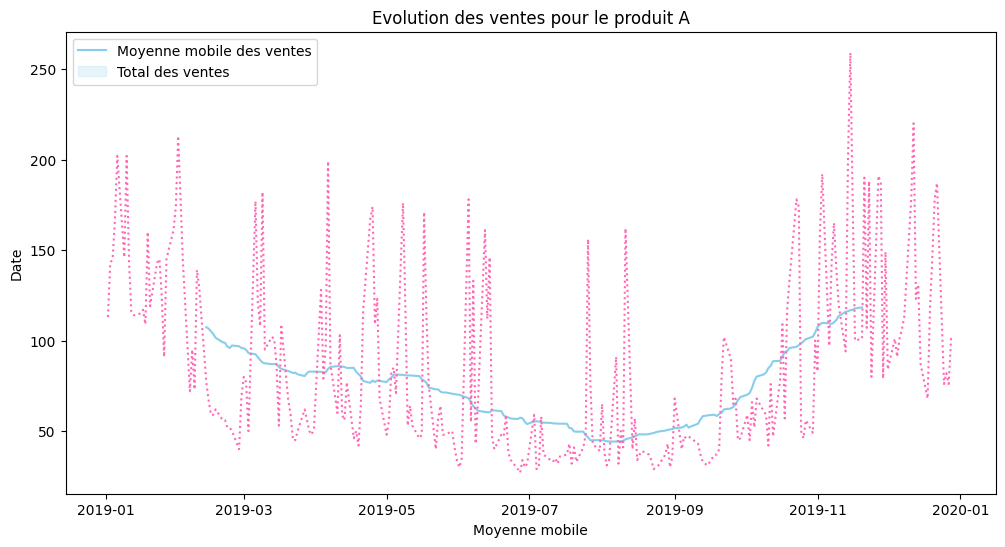

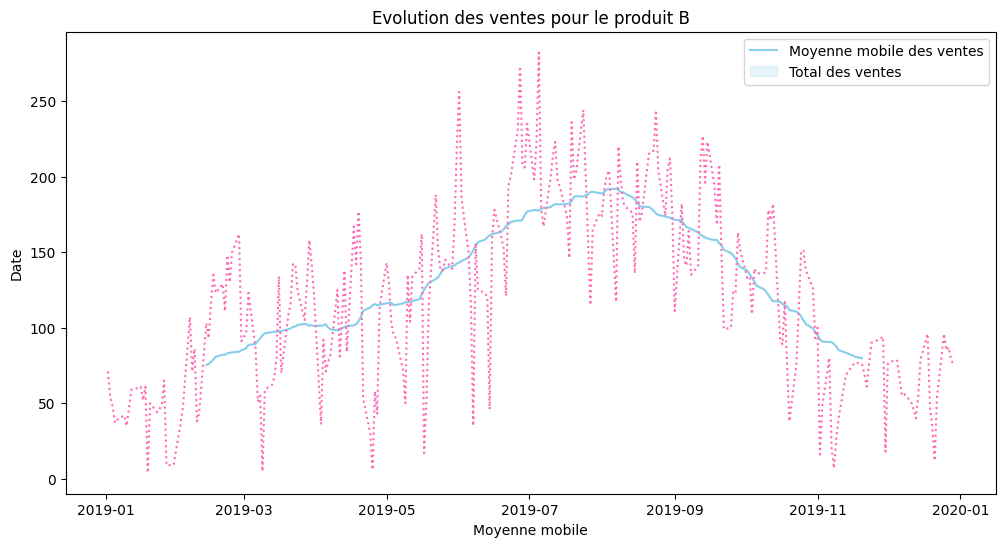

In [29]:
for i in (sales_by_product.item.unique()):
    plot_moving_average(sales_by_product, sales, i)

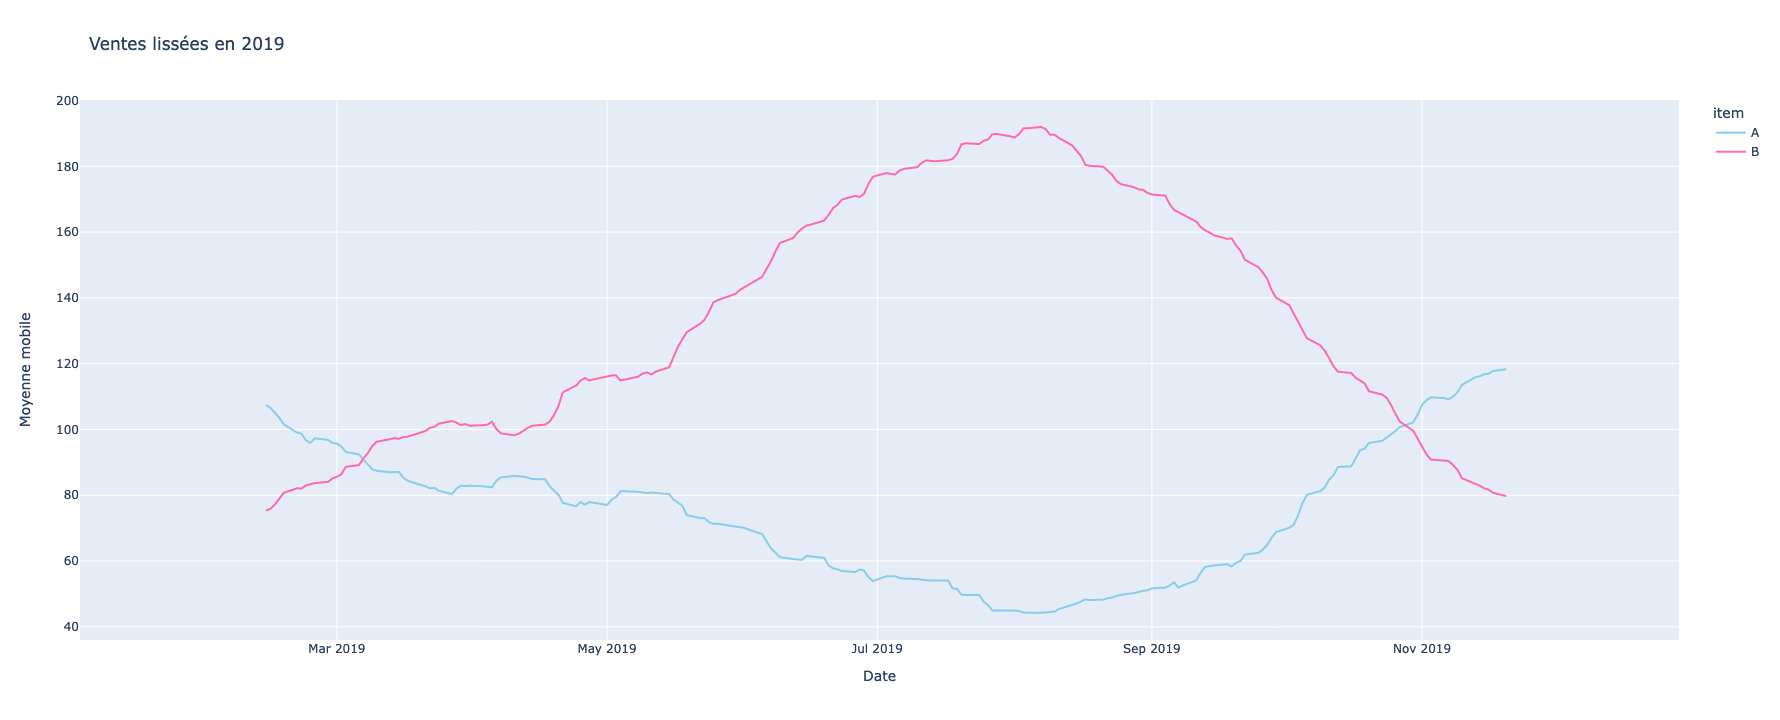

In [30]:
plot_product_sales(dataframe=sales_by_product, x="date", y="moving_average", title="Ventes lissées en 2019", x_title="Date", y_title= "Moyenne mobile")

**Observation**<br>
On confirme l'hypothèse émise plus haut : les produits sont complémentaires, on observe l'inversion des courbes début mars et fin octobre.

Je crée l'indicateur "month" pour suivre l'évolution par mois.

In [31]:
sales_by_product["month"] = sales_by_product.date.dt.month
sales_by_product = sales_by_product.groupby(["item", 'month'], as_index=False).agg(total_per_month=('sales','sum'))
sales_by_product

,item,month,total_per_month
0,A,1,3095
1,A,2,1743
2,A,3,1875
3,A,4,1906
4,A,5,1644
5,A,6,1423
6,A,7,972
7,A,8,1058
8,A,9,1079
9,A,10,1722


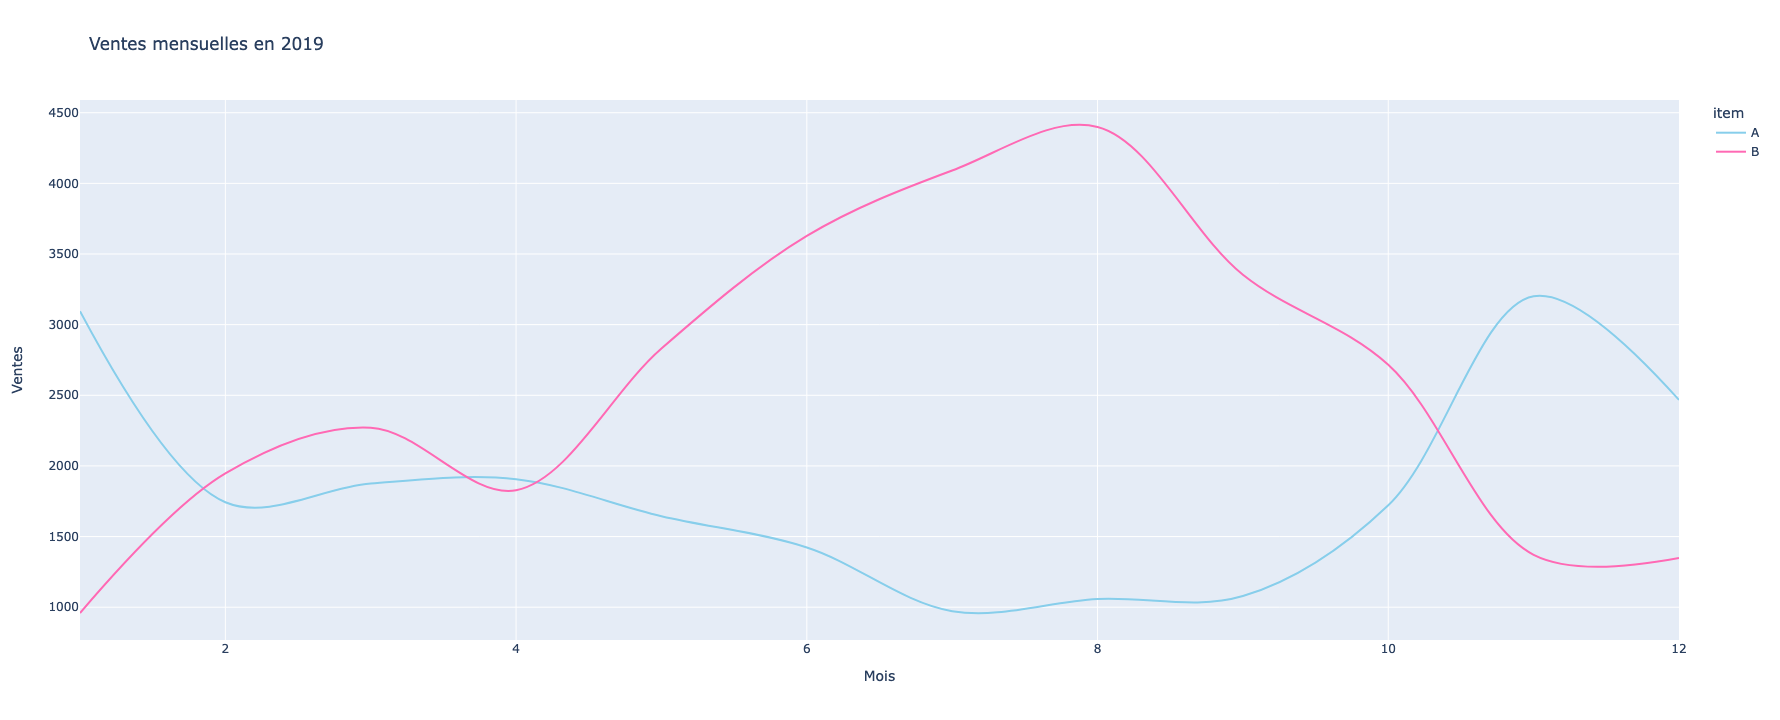

In [32]:
plot_product_sales(dataframe=sales_by_product, x="month", y="total_per_month", title="Ventes mensuelles en 2019", x_title="Mois", y_title= "Ventes", style="spline")

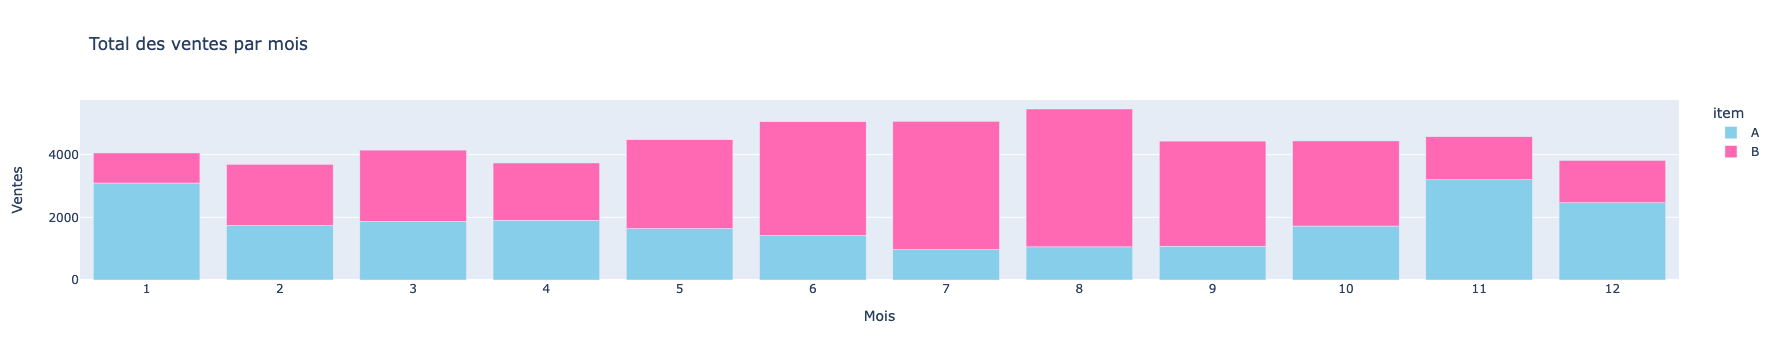

In [33]:
fig = px.bar(sales_by_product, x='month', y='total_per_month', color="item", color_discrete_map=items_color, title="Total des ventes par mois").update_layout(xaxis={"title": "Mois"}, yaxis={"title": "Ventes"})
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
            )
)
fig.show()

## Conclusion

- Il y a 2 **produits** vendus dans la boutiques.
- **Il manque 23 jours de données** sur le produit B : elles ont été remplacées par la moyenne des ventes sur chaque mois.
- Le magasin est fermé 2 jours consécutifs par semaine, le lundi et le mardi.
- On observe une **saisonnalité** des produits : 
    - A est un produit qui se vend mieux en hiver (novembre à janvier)
    - B le reste de l'année

# 2. Trouver la boutique correspondante

D'après Bernardo, "le vent trop fort ne fait que du tort à son activité." <br>
C'est le seul indice pour identifier la boutique. Je vais chercher quelle ville a un vent qui influe sur les ventes.

## Qualité des données

In [34]:
cities = {"lyon":lyon,
          "bordeaux":bordeaux, 
          "lille":lille,
          "marseille":marseille}


In [35]:
for name, df in cities.items() :
    print(colored 
          (f"{name.upper()} - DESCRIPTION DES DONNEES",
           'green',
           attrs=['bold']))
    
    display(df.describe().transpose())
    
    print(colored(
        f"{name.upper()} - TYPE DE DONNEES",
            'green',
            attrs=['bold']))
    print(df.dtypes)
    print("")
    
    print(colored(
        f"{name.upper()} - VALEURS NULLES",
            'green',
            attrs=['bold']))
    print(df.isnull().sum())

    print(f"""
________________________________________________________________________________________________

""")

LYON - DESCRIPTION DES DONNEES


,count,mean,std,min,25%,50%,75%,max
MAX_TEMPERATURE_C,365.0,17.808219,8.582594,-1.000,11.000,17.0,24.00,39.0
MIN_TEMPERATURE_C,365.0,12.813699,7.421629,-4.000,7.000,12.0,18.00,32.0
WINDSPEED_MAX_KMH,365.0,13.893151,7.580490,3.000,8.000,13.0,19.00,45.0
TEMPERATURE_MORNING_C,365.0,10.665753,6.631432,-5.000,6.000,10.0,16.00,27.0
TEMPERATURE_NOON_C,365.0,16.276712,8.126921,-1.000,10.000,16.0,22.00,37.0
TEMPERATURE_EVENING_C,365.0,15.838356,8.660803,-2.000,9.000,15.0,22.00,38.0
PRECIP_TOTAL_DAY_MM,365.0,4.173151,8.460158,0.000,0.000,0.3,4.60,54.7
HUMIDITY_MAX_PERCENT,365.0,71.057534,11.435412,45.000,62.000,71.0,80.00,97.0
VISIBILITY_AVG_KM,365.0,9.859589,2.124530,2.875,9.125,10.0,10.00,20.0
PRESSURE_MAX_MB,365.0,1019.808219,7.460256,995.000,1016.000,1020.0,1024.00,1037.0


LYON - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM             float64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

LYON - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVENING_C   

,count,mean,std,min,25%,50%,75%,max
MAX_TEMPERATURE_C,365.0,18.895890,7.249487,5.000,13.000,18.00,24.000,41.0
MIN_TEMPERATURE_C,365.0,13.997260,6.188210,0.000,10.000,13.00,18.000,30.0
WINDSPEED_MAX_KMH,365.0,13.975342,6.064846,3.000,10.000,13.00,17.000,44.0
TEMPERATURE_MORNING_C,365.0,11.873973,5.266576,-1.000,8.000,12.00,16.000,25.0
TEMPERATURE_NOON_C,365.0,17.353425,7.020263,0.000,12.000,17.00,22.000,38.0
TEMPERATURE_EVENING_C,365.0,17.005479,7.198899,0.000,12.000,16.00,22.000,40.0
PRECIP_TOTAL_DAY_MM,365.0,2.343288,4.467623,0.000,0.000,0.30,2.500,31.7
HUMIDITY_MAX_PERCENT,365.0,73.964384,12.500169,43.000,65.000,75.00,84.000,99.0
VISIBILITY_AVG_KM,365.0,9.834932,2.135091,2.125,9.000,10.00,10.000,20.0
PRESSURE_MAX_MB,365.0,1019.816438,8.004240,991.000,1016.000,1019.00,1025.000,1039.0


BORDEAUX - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM               int64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

BORDEAUX - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVEN

,count,mean,std,min,25%,50%,75%,max
MAX_TEMPERATURE_C,365.0,15.268493,6.924572,0.000,10.00,15.000,20.000,38.0
MIN_TEMPERATURE_C,365.0,11.509589,6.095219,-3.000,7.00,11.000,16.000,29.0
WINDSPEED_MAX_KMH,365.0,18.750685,8.035346,4.000,13.00,18.000,23.000,51.0
TEMPERATURE_MORNING_C,365.0,9.972603,5.254440,-3.000,6.00,10.000,14.000,25.0
TEMPERATURE_NOON_C,365.0,14.142466,6.712828,-1.000,9.00,14.000,19.000,35.0
TEMPERATURE_EVENING_C,365.0,13.841096,6.882208,-2.000,8.00,14.000,19.000,36.0
PRECIP_TOTAL_DAY_MM,365.0,2.536712,4.443234,0.000,0.00,0.500,3.100,29.2
HUMIDITY_MAX_PERCENT,365.0,75.964384,10.854499,47.000,69.00,77.000,84.000,100.0
VISIBILITY_AVG_KM,365.0,9.815068,2.029055,3.125,9.00,10.000,10.000,20.0
PRESSURE_MAX_MB,365.0,1018.010959,10.225743,986.000,1011.00,1018.000,1025.000,1041.0


LILLE - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM             float64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

LILLE - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVENING_C 

,count,mean,std,min,25%,50%,75%,max
MAX_TEMPERATURE_C,365.0,19.252055,6.082494,7.00,14.000,19.00,24.000,32.000
MIN_TEMPERATURE_C,365.0,16.761644,6.419036,0.00,12.000,16.00,22.000,31.000
WINDSPEED_MAX_KMH,365.0,23.986301,12.479096,6.00,14.000,20.00,32.000,67.000
TEMPERATURE_MORNING_C,365.0,16.145205,6.317885,0.00,12.000,15.00,21.000,29.000
TEMPERATURE_NOON_C,365.0,18.515068,6.346923,0.00,13.000,18.00,24.000,32.000
TEMPERATURE_EVENING_C,365.0,18.175342,6.093317,0.00,13.000,18.00,23.000,31.000
PRECIP_TOTAL_DAY_MM,365.0,2.254521,7.854040,0.00,0.000,0.00,0.400,68.900
HUMIDITY_MAX_PERCENT,365.0,61.673973,10.510618,35.00,54.000,61.00,68.000,91.000
VISIBILITY_AVG_KM,365.0,10.252055,2.018500,6.75,10.000,10.00,10.000,20.000
PRESSURE_MAX_MB,365.0,1017.490411,6.819739,997.00,1014.000,1017.00,1021.000,1036.000


MARSEILLE - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM               int64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

MARSEILLE - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EV

**Observations**<br>
A part les dates qui ne sont pas au format date, les autres données semblent correctes.

### Conversion des données

Je mets les noms de colonnes en minuscules et  je convertis la date au format date.

In [36]:
for name, df in cities.items() :
    df.columns = df.columns.str.lower()
    df.date=pd.to_datetime(df.date, format="%Y-%m-%d")
    df.date.dtype

Vérification

In [37]:
lyon.dtypes

date                      datetime64[ns]
max_temperature_c                  int64
min_temperature_c                  int64
windspeed_max_kmh                  int64
temperature_morning_c              int64
temperature_noon_c                 int64
temperature_evening_c              int64
precip_total_day_mm              float64
humidity_max_percent               int64
visibility_avg_km                float64
pressure_max_mb                    int64
cloudcover_avg_percent           float64
heatindex_max_c                    int64
dewpoint_max_c                     int64
windtemp_max_c                     int64
weather_code_morning               int64
weather_code_noon                  int64
weather_code_evening               int64
total_snow_mm                    float64
uv_index                           int64
sunhour                          float64
opinion                           object
dtype: object

## Analyse visuelle entre vent et ventes

In [38]:
sales_by_date=sales.groupby("date", as_index=False).agg({"sales":"sum"})
sales_by_date


,date,sales
0,2019-01-02,184
1,2019-01-03,197
2,2019-01-04,193
3,2019-01-05,204
4,2019-01-06,241
...,...,...
255,2019-12-25,172
256,2019-12-26,167
257,2019-12-27,163
258,2019-12-28,180


Je vais représenter les courbes de vent par ville en fonction des ventes

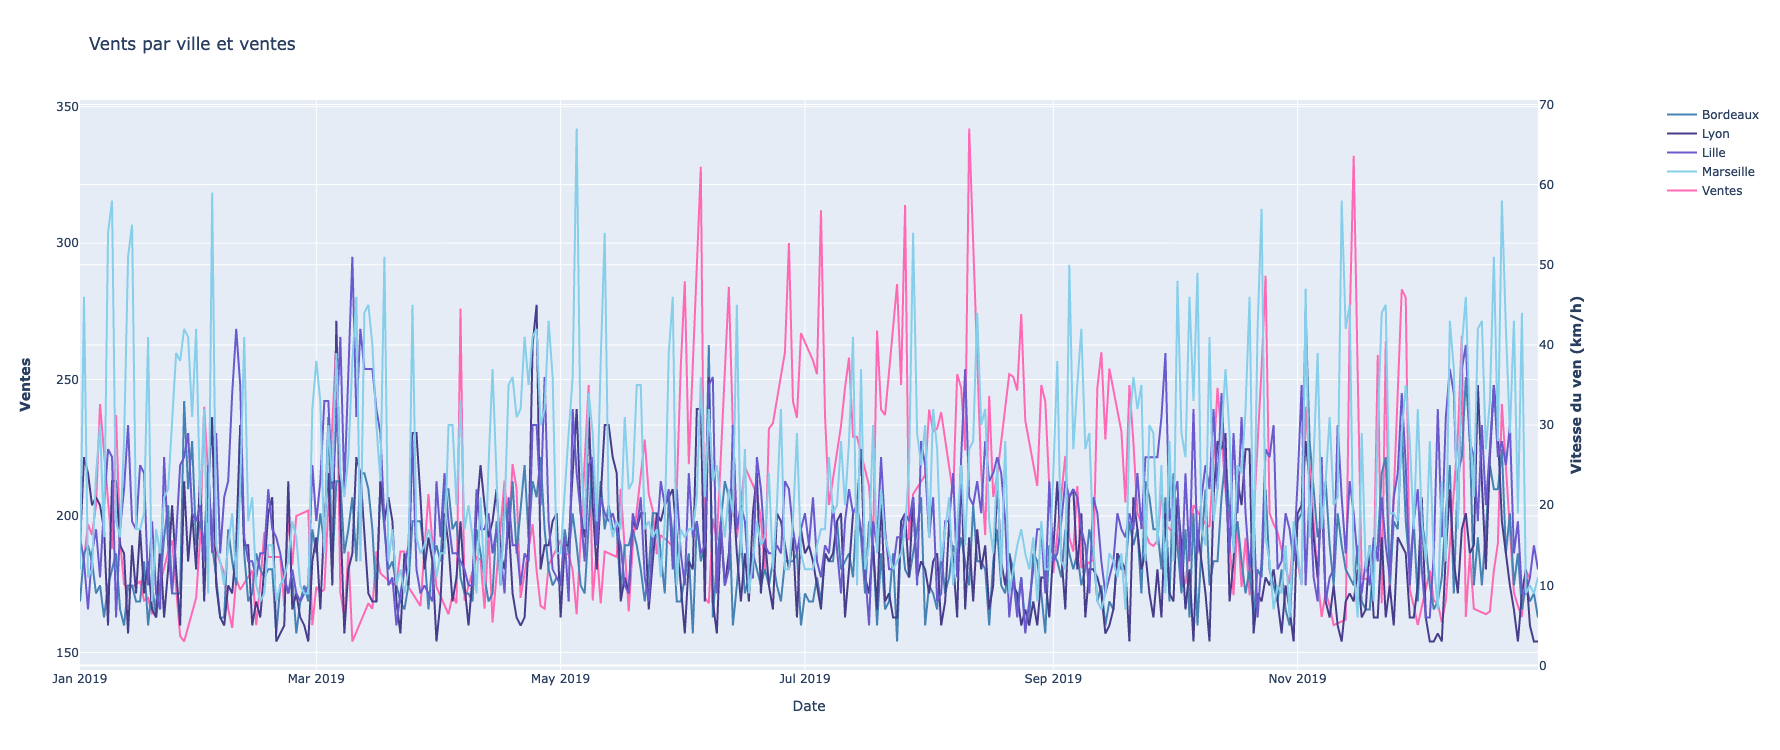

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

marseille_wind = marseille.windspeed_max_kmh
lyon_wind = lyon.windspeed_max_kmh
lille_wind = lille.windspeed_max_kmh
bordeaux_wind = bordeaux.windspeed_max_kmh


fig = go.Figure()
# Create figures with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]],)

fig.add_trace(
    go.Scatter(
        x=bordeaux.date,
        y=bordeaux_wind,
        line_color='steelblue',
        name='Bordeaux'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(   
        x=lyon.date,
        y=lyon_wind,
        line_color='darkslateblue',
        name='Lyon'
    ),
    secondary_y=True   
)

fig.add_trace(
    go.Scatter(
        x=lille.date, y=lille_wind,
        line_color='slateblue',
        name='Lille'
    ),
    secondary_y=True
)


fig.add_trace(go.Scatter(
    x=marseille.date, 
    y=marseille_wind,
    line_color='skyblue',
    name='Marseille'),
    secondary_y=True,
)
fig.add_trace(go.Scatter(
    x=sales_by_date.date, y=sales_by_date.sales,
    line_color='hotpink',
    name='Ventes'),
    secondary_y=False,
)

# Add figure title and dimensions
fig.update_layout(
    autosize=False,
    width=1500,
    height=750,
    title_text="Vents par ville et ventes"
)


# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Ventes</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>Vitesse du ven (km/h)</b>", secondary_y=True)

#fig.update_traces(mode='lines')
fig.show()

Il est assez difficile de trouver une corrélation en analysant le visuel. Il faudrait lisser les données si on veut rester sur une première analyse visuelle.<br>
Je vais partir sur une analyse statistique qui sera plus pertinente.

## Analyse statistique entre vent et ventes

**Méthode**<br>

Je vais d'abord mettre les données dont j'ai besoin dans un seul dataframe.

Avant de faire le test de dépendance, je vais vérifier quelques hypothèses (qui valide que les variables suivent une loi normale):

- l’indépendance entre les échantillons de chaque groupe : on considère ici que les échantillons sont bien indépendants.
- l’égalité des variances que l’on peut vérifier avec un test de *Bartlett*.
- la normalité des résidus avec un test de *Shapiro*.

In [40]:
df_merged=pd.DataFrame()

In [41]:
for name, df in cities.items():
    temp_df_name = str(name)+"_df"
    temp_df_name=df.copy()
    temp_df_name=temp_df_name.loc[:,["windspeed_max_kmh","date"]].rename(columns={'windspeed_max_kmh' : 'windspeed_max_kmh_' + name})
    
    if df_merged.empty:
        df_merged = pd.merge(
            sales_by_date, temp_df_name,
            on=['date'],
            how='inner'
        )
    else :
        df_merged = pd.merge(
            df_merged, temp_df_name,
            on=['date'],
            how='inner'
        )          
          

In [42]:
df_merged

,date,sales,windspeed_max_kmh_lyon,windspeed_max_kmh_bordeaux,windspeed_max_kmh_lille,windspeed_max_kmh_marseille
0,2019-01-02,184,26,14,13,46
1,2019-01-03,197,24,15,7,11
2,2019-01-04,193,20,13,14,12
3,2019-01-05,204,21,9,17,24
4,2019-01-06,241,20,10,11,30
...,...,...,...,...,...,...
255,2019-12-25,172,7,10,14,43
256,2019-12-26,167,3,14,18,19
257,2019-12-27,163,9,7,9,44
258,2019-12-28,180,12,10,9,9


### Egalité des variances

Le test de bartlett permet de tester si les variances sont significativement différentes ou non.

- H0 : Les variances de chaque groupe sont égales si p-value > 0.05
- Ha : Les variances de chaque groupe ne sont pas toutes égales si p-value < 0.05


In [43]:
for column in df_merged.iloc[:,2:6]:
    bartlett_pvalue = bartlett(df_merged["sales"], df_merged[column])[1]
    if bartlett_pvalue > alpha :
        print (
            colored(
                f"La p-value est supérieure à 0.05 ({bartlett_pvalue:.2e}), la variance entre les ventes et le vent à {str(column)[18:].capitalize()} est égale : la distribution est normale.",
                "blue",
                attrs=['bold']
            )
        )
    else:
        print (
            colored(
                f"La p-value est inférieure au seuil alpha 0.05 ({bartlett_pvalue:.2e}), la variance entre les ventes et le vent à {str(column)[18:].capitalize()} n'est pas égale : la distribution n'est pas normale.",
                "red"
            )
        )

La p-value est inférieure au seuil alpha 0.05 (4.37e-106), la variance entre les ventes et le vent à Lyon n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (2.45e-130), la variance entre les ventes et le vent à Bordeaux n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (4.98e-97), la variance entre les ventes et le vent à Lille n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (4.33e-59), la variance entre les ventes et le vent à Marseille n'est pas égale : la distribution n'est pas normale.


### Normalité des résidus

L’objectif est de s’assurer que les résidus suivent une loi normale afin de ne pas affirmer qu’il existe une différence de moyenne entre les groupes qui serait causée par le hasard.

On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

H0 : Les résidus suivent une loi normale si p-value > 0.05<br>
Ha : Les résidus ne suivent pas une loi normale si p-value < 0.05

In [44]:
for column in df_merged.iloc[:,2:6]:
    model = ols('sales ~  df_merged[column]', data=df_merged).fit()
    shapiro_pvalue = shapiro(model.resid)[1]
    if shapiro_pvalue > alpha :
        print (
            colored(
                f"La p-value est supérieure au seuil alpha 0.05 (({shapiro_pvalue:.2e}), les résidus entre les ventes et le vent à {str(column)[18:].capitalize()} suivent une loi normale.",
                'blue',
                attrs=['bold']
            )
        )
           
    else :
        print( 
            colored(
                f"La p-value est inférieure à 0.05 ({shapiro_pvalue:.2e}), les résidus entre les ventes et le vent à {str(column)[18:].capitalize()} ne suivent pas une loi normale.",
                "red"
            )
        )


La p-value est inférieure à 0.05 (2.30e-12), les résidus entre les ventes et le vent à Lyon ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (2.56e-12), les résidus entre les ventes et le vent à Bordeaux ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (4.31e-12), les résidus entre les ventes et le vent à Lille ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (2.58e-12), les résidus entre les ventes et le vent à Marseille ne suivent pas une loi normale.


**Conclusion**<br>
Notre échantillon étant petit et nos données ne suivant pas de loi normale, il faut utiliser des tests non paramétriques.

### Test de corrélation entre les données de vente et le vent

**Méthode**<br>
Je vais regarder si on peut considérer qu'une relation existe entre les ventes et le vent par ville.

**Hypothèses**<br>
- H0 : Variables indépendantes si p-value > alpha,<br>
- H1 : Variables dépendantes si p-value < alpha,<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

Je regarde d'abord la matrice de corrélation avec les coefficients.<br>


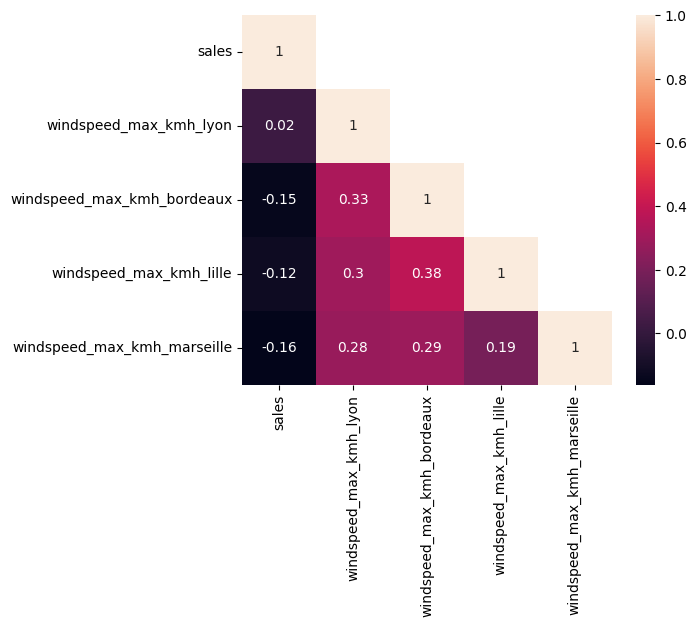

In [45]:
corr_matrix = df_merged.iloc[:,1:6].corr(method="spearman") # j'utilise Spearman car les données ne sont pas normalisées
mask = np.triu(np.ones_like(corr_matrix,dtype=bool),k=1)
sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, cbar=True, cbar_kws={"shrink": 1} )
plt.show()


In [166]:
for column in df_merged.iloc[:,2:6]:
    coeff = spearmanr(df_merged.sales, df_merged[column])
    spearman_pvalue = coeff[1]
    if spearman_pvalue > alpha :
        print (colored (f"La p-value est supérieure à 0.05 ({spearman_pvalue}), il y a une corrélation entre les ventes et le vent à {str(column)[18:].capitalize()}.", 'blue',attrs=['bold']))
    else:
        print (colored (f"La p-value est inférieure au seuil alpha 0.05 ({spearman_pvalue}), il n'y a pas de corrélation entre les ventes et le vent à {str(column)[18:].capitalize()}.", 'red'))
    

La p-value est supérieure à 0.05 (0.7468619227146998), il y a une corrélation entre les ventes et le vent à Lyon.
La p-value est inférieure au seuil alpha 0.05 (0.018993421902834037), il n'y a pas de corrélation entre les ventes et le vent à Bordeaux.
La p-value est supérieure à 0.05 (0.05399761511183216), il y a une corrélation entre les ventes et le vent à Lille.
La p-value est inférieure au seuil alpha 0.05 (0.00905891926392173), il n'y a pas de corrélation entre les ventes et le vent à Marseille.


## Conclusion
Si l'on se base uniquement sur le vent, c'est Lyon qui est le plus corrélé aux ventes. Lille semble également avoir cette dépendance mais dans une moindre mesure.

# 3. Explication de l'impact de la météo

Je vais commencer par supprimer les colonnes que je juge inutile dans les données météos de Lyon.

In [118]:
lyon_df = lyon.copy()

Je supprime les colonnes "weather_code_x"

In [119]:
lyon_df.dtypes

date                      datetime64[ns]
max_temperature_c                  int64
min_temperature_c                  int64
windspeed_max_kmh                  int64
temperature_morning_c              int64
temperature_noon_c                 int64
temperature_evening_c              int64
precip_total_day_mm              float64
humidity_max_percent               int64
visibility_avg_km                float64
pressure_max_mb                    int64
cloudcover_avg_percent           float64
heatindex_max_c                    int64
dewpoint_max_c                     int64
windtemp_max_c                     int64
weather_code_morning               int64
weather_code_noon                  int64
weather_code_evening               int64
total_snow_mm                    float64
uv_index                           int64
sunhour                          float64
opinion                           object
dtype: object

In [120]:
lyon_df.drop(columns=["weather_code_morning", "weather_code_noon", "weather_code_evening"], inplace=True)

Les colonnes *max_temperature_c* et *heatindex_max_c* ont l'air identique. <br>
Je vérifie avant de supprimer l'une des colonnes.

In [121]:
j=0
for i in range(len(lyon)) :
    if lyon_df["max_temperature_c"][i] != lyon_df["heatindex_max_c"][i]:
        j=j+1
print(
    f"Il y a {j} lignes où les données ne sont pas égales."
)

Il y a 106 lignes où les données ne sont pas égales.


Je transforme la colonne opinion qui est qualitative en données quantitative. <br>
J'utilise le LabelEncoder.

label_encoder = LabelEncoder()
label_encoder.fit(lyon_df.opinion)
label_encoder.classes_
lyon_df.opinion = label_encoder.transform(lyon_df.opinion)

Je vais remanier le classement pour indiquer que l'opinion a une hiérarchie (finalement, j'aurais pu le faire directement...).<br>
L'encodage réalisé donne : 
- 0 = 'météo correcte'
- 1 = 'météo défavorable'
- 2 = 'météo favorable'
- 3 = 'météo idéale'
- 4 = 'météo très défavorable'

Je souhaite :
- 0 = 'météo très défavorable'
- 1 = 'météo défavorable'
- 2 = 'météo correcte'
- 3 = 'météo favorable'
- 4 = 'météo idéale'

J'inverse ma transformation
lyon_df.opinion=label_encoder.inverse_transform(lyon_df.opinion)

dict_opinion ={
    'météo très défavorable' :0,
    'météo défavorable':1,
    'météo correcte':2,
    'météo favorable':3,
    'météo idéale':4
}  

for i in range(len(lyon_df)):
    if lyon_df.opinion.loc[i] in dict_opinion.keys():
        lyon_df.loc[i,"opinion"] = (dict_opinion.get(lyon_df.loc[i,"opinion"]))

lyon_df.opinion = lyon_df.opinion.astype(int)

In [133]:
lyon_df=lyon_df.merge(sales_by_date, how='inner', on = "date")
lyon_df

Je déplace ma colonne qualitative opinion en début de tableau pour simplifier les filtres sur les données numériques.

In [136]:
col_to_move = lyon_df.pop("opinion")
lyon_df.insert(1,"opinion",col_to_move)
lyon_df

,date,opinion,max_temperature_c,min_temperature_c,windspeed_max_kmh,temperature_morning_c,temperature_noon_c,temperature_evening_c,precip_total_day_mm,humidity_max_percent,visibility_avg_km,pressure_max_mb,cloudcover_avg_percent,heatindex_max_c,dewpoint_max_c,windtemp_max_c,total_snow_mm,uv_index,sunhour,sales
0,2019-01-02,météo très défavorable,5,3,26,4,5,3,0.0,81,10.0,1036,29.625,5,2,-2,0.0,2,8.7,184
1,2019-01-03,météo très défavorable,4,1,24,0,3,1,0.0,68,10.0,1036,0.375,4,0,-4,0.0,2,8.7,197
2,2019-01-04,météo très défavorable,4,1,20,0,4,2,0.0,77,10.0,1037,12.125,4,0,-4,0.0,2,8.7,193
3,2019-01-05,météo très défavorable,4,1,21,0,3,3,0.0,81,10.0,1037,80.625,4,0,-4,0.0,2,3.3,204
4,2019-01-06,météo très défavorable,4,3,20,2,3,3,0.2,83,10.0,1035,80.250,4,1,-2,0.0,1,3.3,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2019-12-25,météo défavorable,10,7,7,7,10,9,0.2,81,10.0,1026,40.500,10,7,7,0.0,3,3.3,172
256,2019-12-26,météo très défavorable,8,5,3,4,8,7,0.0,86,10.0,1029,51.000,8,4,5,0.0,3,6.9,167
257,2019-12-27,météo défavorable,9,7,9,7,9,8,9.4,91,8.5,1031,87.750,9,7,6,0.0,2,3.3,163
258,2019-12-28,météo très défavorable,7,5,12,5,7,5,0.0,88,10.0,1034,75.250,7,4,4,0.0,3,3.3,180


## Impact générale

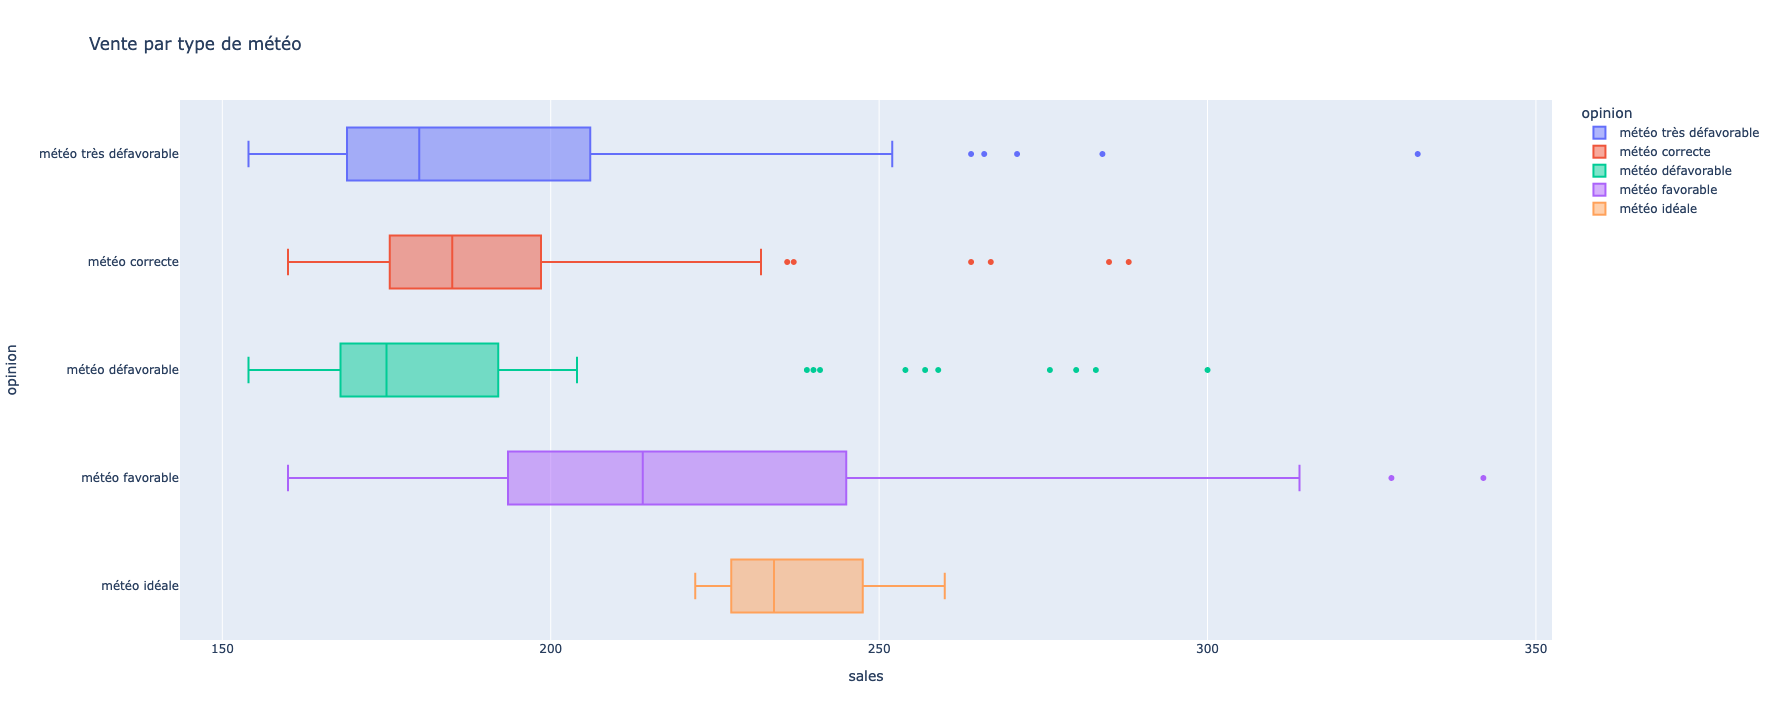

In [164]:
fig = px.box(
    data_frame=lyon_df,
    x="sales",
    y="opinion",
    width=1080, 
    height=720,
    color="opinion",
    title="Vente par type de météo"
)

fig.show()

**Observation**<br>
La météo qualifiée d'idéale enregistre le plus grand nombre de vente, avec une distribution peu étalée : on vend bien ces jours-ci!<br>
La météo favorable arrive ensuite et les pires ventes sont enregistrées les jours de météo défavorable à très défavorable.<br>
Ce graphique nous montre qu'il y a un lien entre la météo et le nombre de vente.<br>
Identifions les variables qui influent le plus sur les ventes.


## Sélection de variables
On va trouver les variables les plus utiles

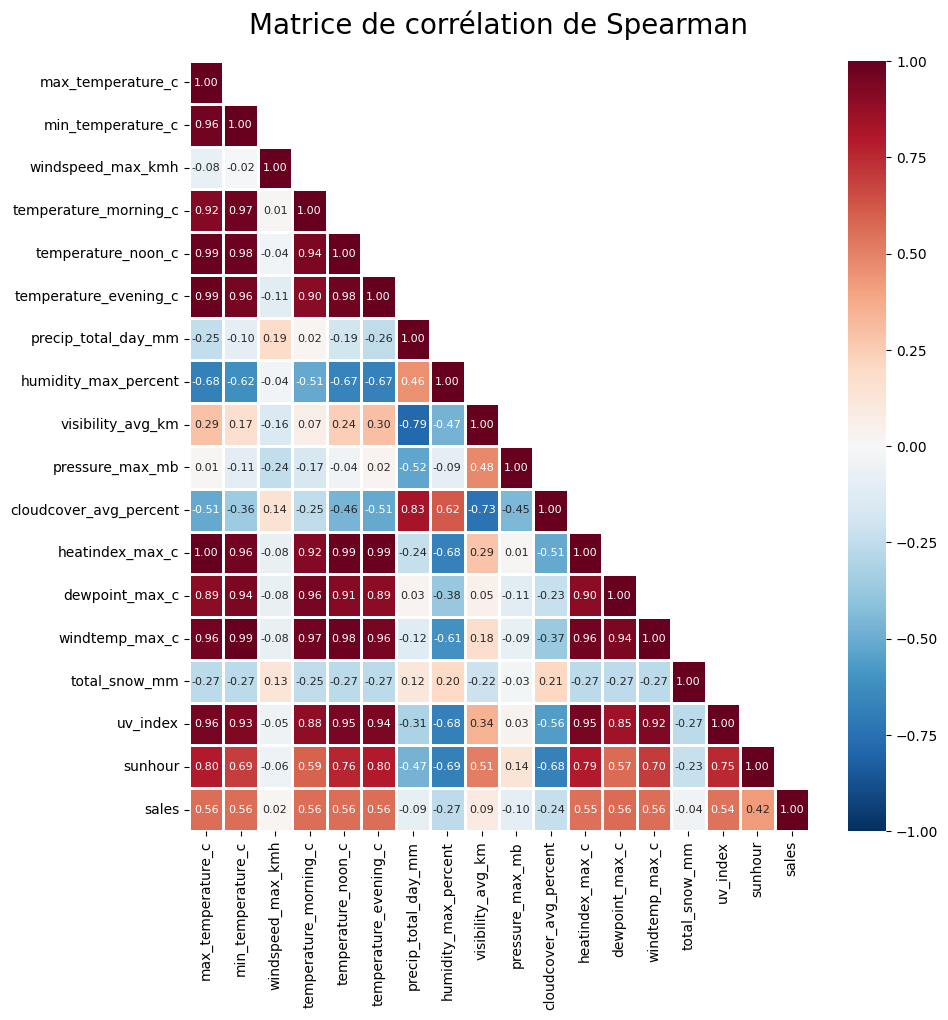

In [ ]:
lyon_corr = (lyon_df.iloc[:,2:]).corr(method = "spearman")

mask = np.triu(np.ones_like(lyon_corr, dtype=bool),k=1)

plt.figure(figsize=(10,10))
sns.heatmap(
    lyon_corr, 
    cmap = 'RdBu_r', 
    mask=mask,
    annot=True,
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f", 
    linewidths=1,
    annot_kws={"size":8},
)

plt.title("Matrice de corrélation de Spearman", fontsize=20, loc='center', pad=20)

plt.show()

## Sélecteur : variance

VarianceThreshold : sélectionne les variables selon leur degré de variation élimine les variables dont la variance est inférieure au seuil défini.


In [ ]:
## Sélecteur : statistique

Tests de dépendances.

In [ ]:
notrend = detrend(df_merged.sales)
df_merged["notrend"] = notrend
df_merged.plot(x="date", y=["sales", "notrend"], figsize=(14,4))

In [ ]:
x = df_merged['date'].values
y1 = df_merged['sales'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-350, 350)
plt.title('Ventes', fontsize=16)
plt.hlines(y=0, xmin=np.min(df_merged['date']), xmax=np.max(df_merged['date']), linewidth=.5)
plt.show()



In [ ]:
fig=px.line(
    data_frame=marseille), 
    x=x, 
    y=y,
    title=title, color="item",
    color_discrete_map=items_color,
    width=1080, height=720,
    line_shape=style).update_layout(xaxis={"title": x_title}, yaxis={"title": y_title})

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [ ]:
plot_product_sales(dataframe=sales_by_product, x="month", y="total_per_month", title="Ventes mensuelles en 2019", x_title="Mois", y_title= "Ventes", style="spline")

In [ ]:
max(lille.windspeed_max_kmh)

In [ ]:
sns.lineplot(data=bordeaux, x="date", y="windspeed_max_kmh")

In [ ]:
title = 'Main Source for News'
labels = lyon.date.strftime("%Y-%m-%d")
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)', 'rgb(19,19,19)']

mode_size = [8, 8, 12, 8,8]
line_size = [2, 2, 4, 2, 2]

x_data = lyon.date

y_data = np.array([
    list(lyon.windspeed_max_kmh),
    list(marseille.windspeed_max_kmh),
    list(lille.windspeed_max_kmh),
    list(bordeaux.windspeed_max_kmh),
    list(sales.sales)
])
    
fig = go.Figure()

for i in range(0, 5):
    fig.add_trace(go.Scatter(x=[x_data[i]], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

    # endpoints
    fig.add_trace(go.Scatter(
        x=[[x_data[i]][0], [x_data[i]][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []

# Adding labels
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}%'.format(y_trace[0]),
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
                                  xanchor='left', yanchor='middle',
                                  text='{}%'.format(y_trace[11]),
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Main Source for News',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: PewResearch Center & ' +
                                   'Storytelling with data',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()


In [ ]:
fig=px.line(
    sales=sales.query("item in ['A','B']"), 
    x=x, 
    y=y,
    title=title, color="item",
    color_discrete_map=items_color,
    width=1080, height=720,
    line_shape=style).update_layout(xaxis={"title": x_title}, yaxis={"title": y_title})

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [ ]:
sns.lineplot(data=lyon, x="date", y= "windspeed_max_kmh")
sns.lineplot(data=sales, x="date", y="sales" )

In [ ]:
sns.lineplot(data=marseille, x="date", y= "windspeed_max_kmh")
sns.lineplot(data=sales, x="date", y="sales" )

In [ ]:
sns.lineplot(x=bordeaux.windspeed_max_kmh, y=sales.sales )

In [ ]:
'''
Plot the distribution of sales by product
Parameters :
    dataframe
    item to plot
'''
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
def plot_sales_by_item (df, item) :
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.autofmt_xdate(rotation=45)

    sns.lineplot(data=df, x="date", y="sales")
    plt.title(f"Vente du produit {item} en 2019", size=20, pad=20)
    ax.xaxis.set_major_locator(MultipleLocator(15))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    #ax.xaxis.set_minor_formatter(FormatStrFormatter('% 1.2f'))
    plt.xlabel("Date")
    plt.ylabel("Ventes")
    plt.show()
    plt.close()
 

In [ ]:
import plotly.graph_objs as go

trace = dict(
    x = sales_by_product.query("item in ['A','B']")['month'],
    y = sales_by_product['total_per_month'],
    mode = 'lines+markers',
    type = 'scatter',
    name = 'count',
    line = dict(shape = 'spline', color = 'rgb(205, 12, 24)', width= 4, dash = 'dash'),
    marker = dict(symbol = "star-diamond", color = 'rgb(17, 157, 255)',size = 8),
    connectgaps = True
)

# Create layout parameter to assing axes titles and set margins
layout =  dict(
    xaxis = dict(title = 'Week'),
    yaxis = dict(title = 'Count'),
    margin = dict(
        l=70,
        r=10,
        b=50,
        t=10
    )
)

# Compose the final figure
data = [trace]
fig =  go.Figure(data = data, layout = layout)

# Use Sisense for Cloud Data Teams to visualize a dataframe, text, or an image by passing data to periscope.table(), periscope.text(), or periscope.image() respectively.
fig.show()

In [ ]:
import plotly.graph_objs as go

trace = dict(
    x = sales_by_product.query("item in ['A','B']")['month'],
    y = sales_by_product['total_per_month'],
    mode = 'lines+markers',
    type = 'scatter',
    name = 'count',
    line = dict(shape = 'spline', color = 'rgb(205, 12, 24)', width= 4, dash = 'dash'),
    marker = dict(symbol = "star-diamond", color = 'rgb(17, 157, 255)',size = 8),
    connectgaps = True
)

# Create layout parameter to assing axes titles and set margins
layout =  dict(
    xaxis = dict(title = 'Week'),
    yaxis = dict(title = 'Count'),
    margin = dict(
        l=70,
        r=10,
        b=50,
        t=10
    )
)

# Compose the final figure
data = [trace]
fig =  go.Figure(data = data, layout = layout)

# Use Sisense for Cloud Data Teams to visualize a dataframe, text, or an image by passing data to periscope.table(), periscope.text(), or periscope.image() respectively.
fig.show()

In [ ]:
'''
Itération sur le tableau.
Si la valeur courante de la colonne "sales" vaut 0, récupération du mois et du produit de la ligne courante.
Recherche de la valeur correspondante dans le dataframe mean_sales_by_month grâce au mois et au produit qui sont l'index du dataframe (ex : mean_sales_by_month.loc[('A',  1), "mean"])
Affectation de la valeur pour remplacement de 0.

L'affectation ne marche pas?
'''
for index, row in sales.iterrows():
    if row["sales"]==0:
        print (row["sales"])
        month=row["month"]
        product=row["item"]
        mean_to_impute=mean_sales_by_month.loc[(product, month), "mean"]
        print (f"On affecte {mean_to_impute} (mois {month} et produit {product}) à l'index {index}.")
        row["sales"]=mean_to_impute
        print(row["sales"])

Je vais imputer en fonction de la date et du produit et renseigner la valeur moyenne des ventes du mois.

In [ ]:
sales["month"] = sales.date.dt.month

In [ ]:
mean_sales_by_month=sales.groupby(["item", "month"], as_index=True).agg(mean=("sales","mean")).astype(int)
mean_sales_by_month

In [ ]:
'''
Itération sur le tableau.
Si la valeur courante de la colonne "sales" vaut 0, récupération du mois et du produit de la ligne courante.
Recherche de la valeur correspondante dans le dataframe mean_sales_by_month grâce au mois et au produit qui sont l'index du dataframe (ex : mean_sales_by_month.loc[('A',  1), "mean"])
Affectation de la valeur pour remplacement de 0.
'''
for index in range(len(sales)):
    if sales.sales.iloc[index]==0:
        month=sales.loc[index,"month"]
        product=sales.loc[index, "item"]
        mean_to_impute=mean_sales_by_month.loc[(product, month), "mean"]
        print (f"On affecte {mean_to_impute} (mois {month} et produit {product}) à l'index {index}.")
        #sales["sales"].iloc[index]=mean_to_impute
        sales.loc[index, "sales"]=mean_to_impute


Vérification

In [ ]:
sales[sales.sales==0]